In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [18]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

# pipeline.py

import xml.etree.ElementTree as ET

# Define helper functions and required variables, or pass them as parameters.
ANNOTATION_PATH = 'face-mask-detection/versions/1/annotations'
IMAGE_PATH = 'face-mask-detection/versions/1/images/'
label_pair = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

def build_pipeline():
    # Step 1: Create a dataframe from XML annotations
    xml_files = [os.path.join(ANNOTATION_PATH, filename) 
                 for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]
    data = []
    for xml_file in xml_files:
        annotations_tmp = parse_xml(xml_file)
        for ann in annotations_tmp:
            data.append([ann['filename'], ann['label'], ann['bbox']])
    df = pd.DataFrame(data, columns=['filename','label','bbox'])
    
    # Step 2: Process images into a form ready for model input
    face_images = []
    face_labels = []
    for idx, row in df.iterrows():
        bbox = row['bbox']
        image = cv2.imread(os.path.join(IMAGE_PATH, row['filename']))
        image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
        blurred = cv2.GaussianBlur(image,(9, 9), 10.0)
        alpha = 1.5  # Sharpening factor
        image = cv2.addWeighted(image, 1 + alpha, blurred, -alpha, 0)
        image = cv2.resize(image, (224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        face_images.append(image)
        face_labels.append(label_pair[row['label']])
        
    face_images = np.array(face_images, dtype='float32')
    
    return df, face_images, face_labels

In [19]:
import pickle

# Build the pipeline using the function from cell 1
pipeline_data = {}
pipeline_data['df'], pipeline_data['face_images'], pipeline_data['face_labels'] = build_pipeline()

# Store the pipeline data in a pickle file
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline_data, f)

print("Pipeline stored in pipeline.pkl")

Pipeline stored in pipeline.pkl


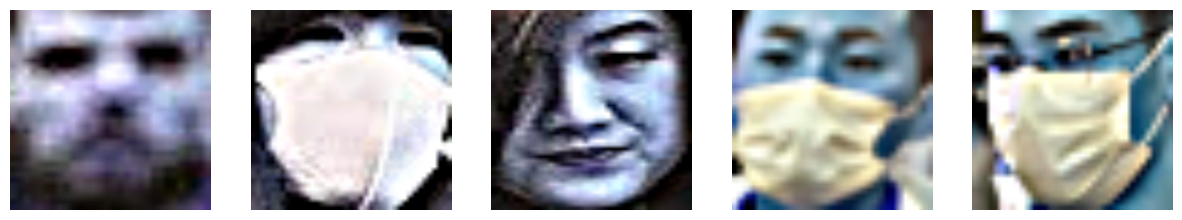

In [20]:
import pickle

# Load the pipeline.pkl file
with open('pipeline.pkl', 'rb') as f:
    pipeline_data = pickle.load(f)

face_images = pipeline_data['face_images']

# Display the preprocessed images (convert InceptionV3 images from [-1, 1] back to [0, 255])
n = 5  # number of images to display
plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    img = face_images[i]
    img_disp = ((img + 1.0) * 127.5).clip(0, 255).astype('uint8')
    plt.imshow(img_disp)
    plt.axis('off')
plt.show()
